In [9]:
######################################
### Sistemas Baseados em Conhecimento
### Notebook: N01 (Redes Bayesianas)   
######################################

## https://pomegranate.readthedocs.io/en/latest/
## Pacote para implementacao de modelos probabilisticos
## !pip install pomegranate

from pomegranate import *

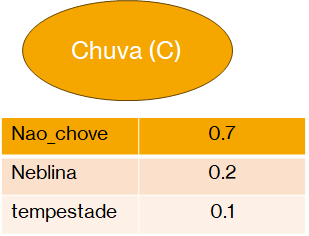

In [12]:
chuva = DiscreteDistribution({
    "nao_chove": 0.7,
    "neblina": 0.2,
    "tempestade": 0.1
})


NameError: name 'Discrete_Distribution' is not defined

CRIACAO DE NOS CONDICIONAIS

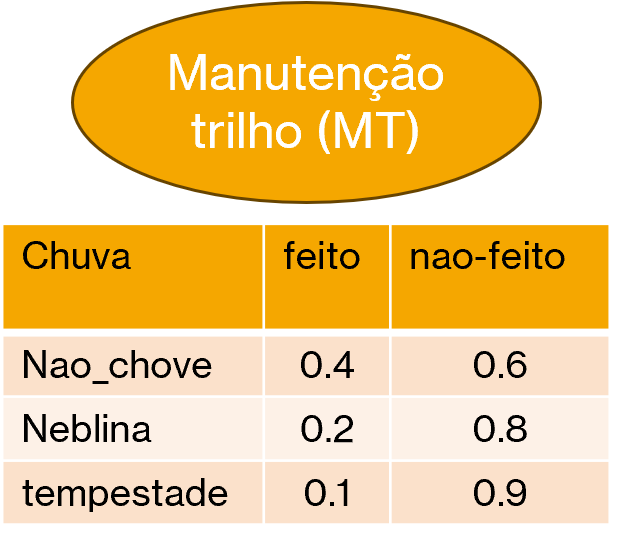

In [ ]:
manutencao = Node(ConditionalProbabilityTable([
    ["nao_chove","feito", 0.4],
    ["nao_chove","nao_feito", 0.6],
    ["neblina","feito", 0.2],
    ["neblina","nao_feito", 0.8],
    ["tempestade","feito", 0.1],
    ["tempestade", "nao_feito", 0.9]
], [chuva.distribution]), name="manutencao")    

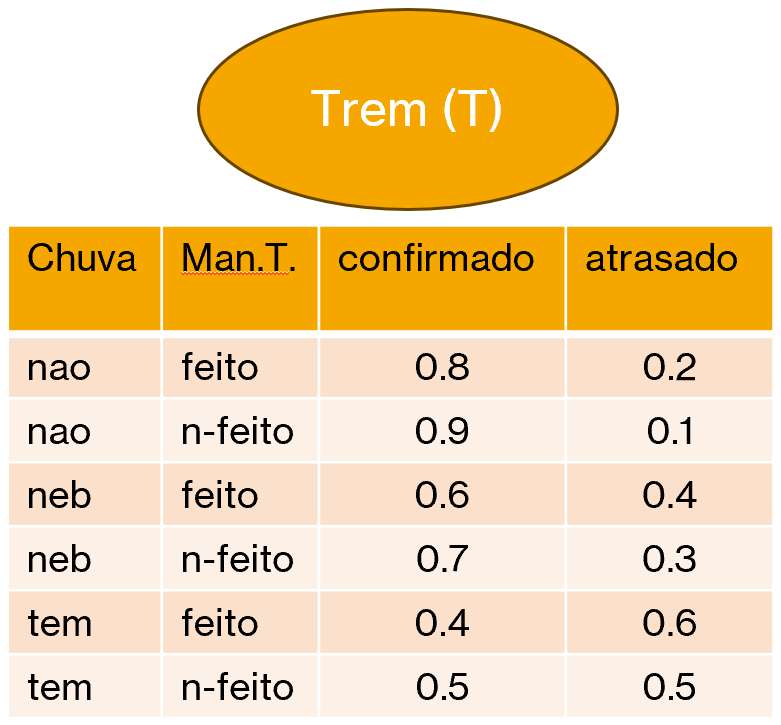

In [ ]:
trem = Node(ConditionalProbabilityTable([
    ["nao_chove", "feito", "confirmado", 0.8],
    ["nao_chove", "feito", "atrasado", 0.2],
    ["nao_chove", "nao_feito", "confirmado", 0.9],
    ["nao_chove", "nao_feito", "atrasado", 0.1],
    ["neblina", "feito", "confirmado", 0.6],
    ["neblina", "feito", "atrasado", 0.4],
    ["neblina", "nao_feito", "confirmado", 0.7],
    ["neblina", "nao_feito", "atrasado", 0.3],
    ["tempestade", "feito", "confirmado", 0.4],
    ["tempestade", "feito", "atrasado", 0.6],
    ["tempestade", "nao_feito", "confirmado", 0.5],
    ["tempestade", "nao_feito", "atrasado", 0.5],
], [chuva.distribution, manutencao.distribution]), name="trem")

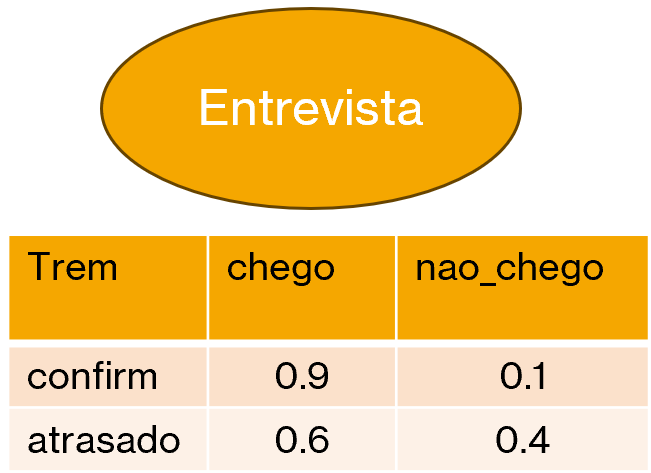

In [ ]:
entrevista = Node(ConditionalProbabilityTable([
    ["confirmado", "chego", 0.9],
    ["confirmado", "nao_chego", 0.1],
    ["atrasado", "chego", 0.6],
    ["atrasado", "nao_chego", 0.4]
], [trem.distribution]), name="entrevista")

In [ ]:
# Criar modelo

model = BayesianNetwork()
model.add_states(chuva, manutencao, trem, entrevista)

model.add_edge(chuva,manutencao)
model.add_edge(chuva, trem)
model.add_edge(manutencao, trem)
model.add_edge(trem, entrevista)

model.bake()


In [ ]:
#Calcular a probablidade de uma dada observacao

probabilidade = model.probability([["nao_chove", "nao_feito", "confirmado", "chego"]])
print(probabilidade)

In [ ]:
#Calcular a probablidade de uma dada observacao

probabilidade = model.probability([["nao_chove", "nao_feito", "confirmado", "nao_chego"]])
print(probabilidade)

In [ ]:
#Calcular predicao

predictions = model.predict_proba({
    "trem":"atrasado"
})

# Interacao para mostrar todos os valores para cada noo

for node, prediction in zip(model.states, predictions):
    if isinstance(prediction,str):
        print(f"{node.name}: {prediction}")
    else:
        print(f"{node.name}")
        for value, probability in prediction.parameters[0].items():
            print("\t", value, probability)
            

In [ ]:
#Calcular predicao

predictions = model.predict_proba({
    "chuva": "tempestade",
    "trem":"atrasado"
})

# Interacao para mostrar todos os valores para cada no

for node, prediction in zip(model.states, predictions):
    if isinstance(prediction,str):
        print(f"{node.name}: {prediction}")
    else:
        print(f"{node.name}")
        for value, probability in prediction.parameters[0].items():
            print("\t", value, probability)
            

In [ ]:
### Redes Bayesianas, utilizando o metodo sampling (sampling rejection)

import pomegranate 
from collections import Counter

In [ ]:
def generate_sample():
    
    # Mapeamento do nome da variavel aleatoria para o sample gerado
    sample = {}
    
    # Mapeamento da distribuicao para o sample gerado
    parents = {}
    
    # Percorrer todos os estados, comecando do root: chuva, manutencao, trem, entrevista
    for state in model.states:
        
        #if o estado for um condicional
        if isinstance(state.distribution, pomegranate.ConditionalProbabilityTable):
            sample[state.name] = state.distribution.sample(parent_values=parents) # preciso da probabilidade dos pais
        else:
            sample[state.name] = state.distribution.sample()
        
        # acompanhar os values amostrados no mapeamento dos pais
        parents[state.distribution] = sample[state.name]
    
    return sample

In [ ]:
# Computar a distribuicao de chegar na "Entrevista" dado que o trem esta atrasado.

N=1000
data = []
for i in range(N):
    sample = generate_sample()
    if sample["trem"] == "atrasado": #rejeitar os samples que nao me interessam
        data.append(sample["entrevista"])

result = Counter(data) 
print(result)
print(result['chego']/(result['chego'] + result['nao_chego']))
print("ERRO: ",0.6 - (result['chego']/(result['chego'] + result['nao_chego']))) # aqui o valor 0.6 eh o correto
    